# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:

df = pd.read_csv('clothes.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(299999, 5)
(500, 5)


In [3]:
df.head()

,idx,reviewText,overall,summary,class
0,1,"I was so glad when these finally arrived, but ...",2,disappointed...,0
1,2,I ordered these boots and received them in the...,5,UGG classic sand boots ordered at Amazon,1
2,3,"Rolls below the bust line, did not expect it t...",3,product reveiw,0
3,4,Well constructed garment with plenty of interi...,5,Plenty of room,1
4,5,I get lots of compliments on these clogs. I we...,5,Love these clogs!,1


## Quick EDA

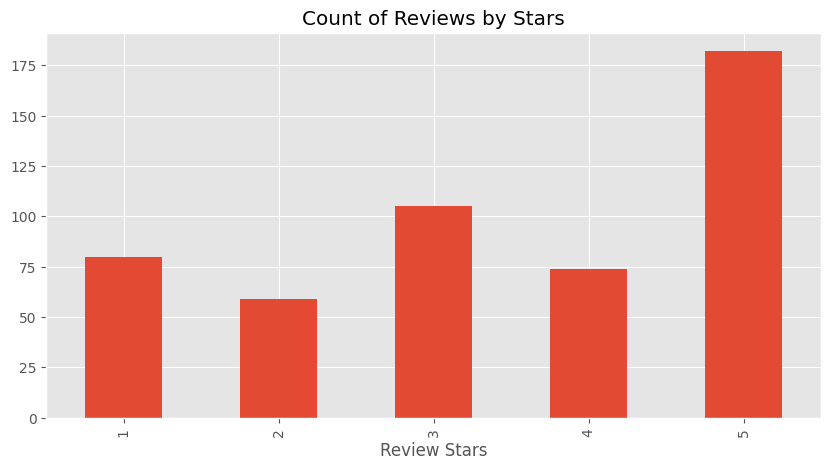

In [4]:
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [5]:
example = df['reviewText'][50]
print(example)

This is my second pair of Sanuks and i absolutely love. They are the most comfortable shoes ever!! I found them to be true to size. They do stretch so I am glad i have not worn them with socks.


In [6]:
tokens = nltk.word_tokenize(example)
tokens

['This',
 'is',
 'my',
 'second',
 'pair',
 'of',
 'Sanuks',
 'and',
 'i',
 'absolutely',
 'love',
 '.',
 'They',
 'are',
 'the',
 'most',
 'comfortable',
 'shoes',
 'ever',
 '!',
 '!',
 'I',
 'found',
 'them',
 'to',
 'be',
 'true',
 'to',
 'size',
 '.',
 'They',
 'do',
 'stretch',
 'so',
 'I',
 'am',
 'glad',
 'i',
 'have',
 'not',
 'worn',
 'them',
 'with',
 'socks',
 '.']

In [7]:
tagged = nltk.pos_tag(tokens)
tagged

[('This', 'DT'),
 ('is', 'VBZ'),
 ('my', 'PRP$'),
 ('second', 'JJ'),
 ('pair', 'NN'),
 ('of', 'IN'),
 ('Sanuks', 'NNP'),
 ('and', 'CC'),
 ('i', 'VB'),
 ('absolutely', 'RB'),
 ('love', 'NN'),
 ('.', '.'),
 ('They', 'PRP'),
 ('are', 'VBP'),
 ('the', 'DT'),
 ('most', 'RBS'),
 ('comfortable', 'JJ'),
 ('shoes', 'NNS'),
 ('ever', 'RB'),
 ('!', '.'),
 ('!', '.'),
 ('I', 'PRP'),
 ('found', 'VBD'),
 ('them', 'PRP'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('true', 'JJ'),
 ('to', 'TO'),
 ('size', 'NN'),
 ('.', '.'),
 ('They', 'PRP'),
 ('do', 'VBP'),
 ('stretch', 'VB'),
 ('so', 'RB'),
 ('I', 'PRP'),
 ('am', 'VBP'),
 ('glad', 'JJ'),
 ('i', 'NNS'),
 ('have', 'VBP'),
 ('not', 'RB'),
 ('worn', 'VBN'),
 ('them', 'PRP'),
 ('with', 'IN'),
 ('socks', 'NNS'),
 ('.', '.')]

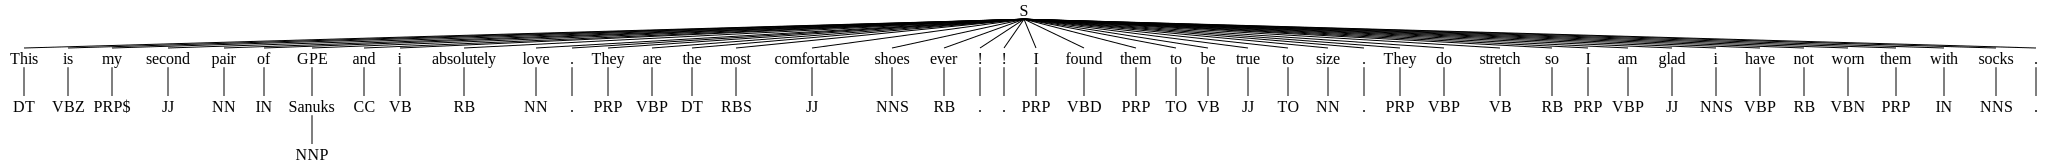

In [8]:
entities = nltk.chunk.ne_chunk(tagged)
entities

# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [9]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dai/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [13]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'compound': 0.9488}

In [14]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['reviewText']
    myid = row['idx']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
vaders = pd.DataFrame(res).T
# vaders = vaders.reset_index().rename(columns={'index': 'Id'})
# vaders = vaders.merge(df, how='left')
vaders

,neg,neu,pos,compound
1,0.094,0.709,0.197,0.9640
2,0.000,0.809,0.191,0.7783
3,0.000,1.000,0.000,0.0000
4,0.000,0.889,0.111,0.5423
5,0.000,0.834,0.166,0.7620
...,...,...,...,...
496,0.067,0.798,0.134,0.4749
497,0.037,0.793,0.170,0.7337
498,0.188,0.611,0.201,-0.1029
499,0.149,0.758,0.093,-0.7531


## Plot VADER results

In [16]:
df = pd.concat([df,vaders],axis=1)

In [17]:
df.overall = df.overall.astype('Int64')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   idx         500 non-null    float64
 1   reviewText  500 non-null    object 
 2   overall     500 non-null    Int64  
 3   summary     500 non-null    object 
 4   class       500 non-null    float64
 5   neg         500 non-null    float64
 6   neu         500 non-null    float64
 7   pos         500 non-null    float64
 8   compound    500 non-null    float64
dtypes: Int64(1), float64(6), object(2)
memory usage: 35.8+ KB


In [19]:
df.dropna(inplace=True)

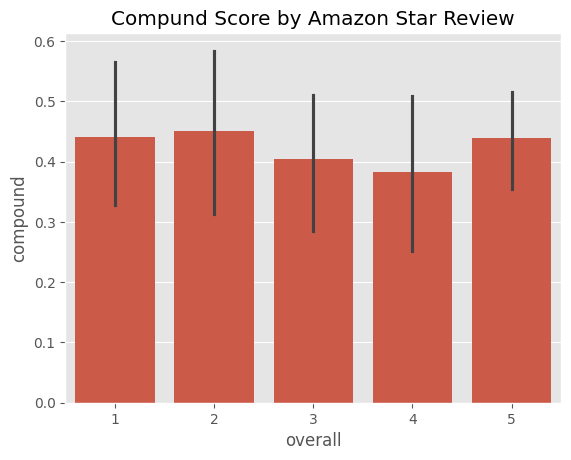

In [20]:
ax = sns.barplot(data=df, x='overall', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

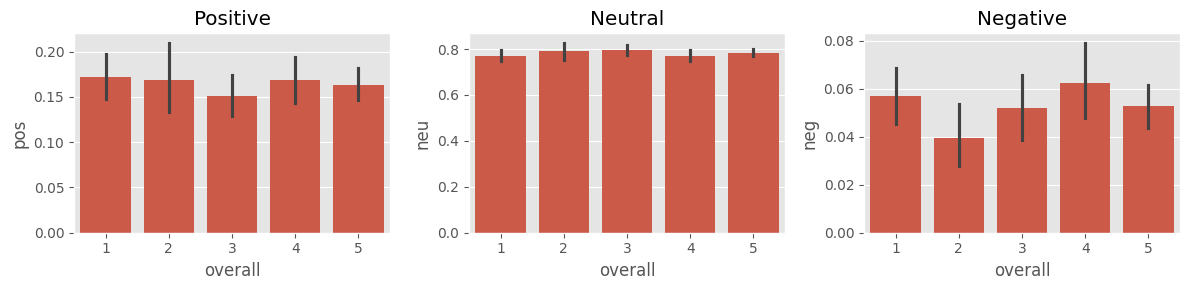

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='overall', y='pos', ax=axs[0])
sns.barplot(data=df, x='overall', y='neu', ax=axs[1])
sns.barplot(data=df, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [24]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This is my second pair of Sanuks and i absolutely love. They are the most comfortable shoes ever!! I found them to be true to size. They do stretch so I am glad i have not worn them with socks.


{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'compound': 0.9488}

In [25]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.001874186, 'roberta_neu': 0.006435048, 'roberta_pos': 0.99169075}


In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [27]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['reviewText']
        myid = row['idx']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/499 [00:00<?, ?it/s]

In [28]:
results_df = pd.DataFrame(res).T
results_df = pd.concat([df,results_df],axis=1)

In [ ]:
results_df.head()

## Compare Scores between models

In [30]:
results_df.columns

Index(['idx', 'reviewText', 'overall', 'summary', 'class', 'neg', 'neu', 'pos',
       'compound', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

# Step 3: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [32]:
results_df.query('overall == 1') \
    .sort_values('roberta_pos', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_8346/3336709947.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 1') \


'The product was great but my husbend could not get them on his swollen feet. 5 stars for quality, zero for ease in putting on.'

In [33]:
results_df.query('overall == 1') \
    .sort_values('vader_pos', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_8346/2150632289.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 1') \


'This is very cheaply made and broke after 2 uses.  We had sprinkles ALL OVER THE KITCHEN.  My daughter actually loved the stupid wand, but 2 hours of cleaning is not worth it for any toy.'

In [34]:
# nevative sentiment 5-Star view

In [35]:
results_df.query('overall == 5') \
    .sort_values('roberta_neg', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_8346/1975733132.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 5') \


'I was told about these at Nordstrom shoes and now I buy them for every pair of taller (3+&#34;) that I have.  They do a great job of preventing my narrow foot from sliding down into the shoe.'

In [36]:
results_df.query('overall == 5') \
    .sort_values('vader_neg', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_8346/1482952078.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 5') \


'You cant beat the price for these scrubs. I would say they run true to size. I usually wear XS in scrubs, that is what I ordered and they fit perfectly.  Usually you pay 17 dollars just for pants, and you get a set for that. Very happy with this product!'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [37]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

2024-02-15 23:39:12.694122: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 23:39:15.504301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 23:39:15.504520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 23:39:15.800389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 23:39:16.511235: I tensorflow/core/platform/cpu_feature_guar

In [38]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [39]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [55]:
output={'labels':None,'Score':None}
scr=[]
lbl=[]
for sent in df['reviewText']:
    for k in sent_pipeline(sent):
        lbl.append(k.get('label'))
        scr.append(k.get('score'))

output['labels']=np.array(lbl)
output['Score']=np.array(scr)


,labels,Score
0,POSITIVE,0.999775
1,NEGATIVE,0.993220
2,POSITIVE,0.990674
3,POSITIVE,0.995875
4,NEGATIVE,0.997420


In [56]:
data=pd.DataFrame(output)
data.head()

,labels,Score
0,POSITIVE,0.999775
1,NEGATIVE,0.993220
2,POSITIVE,0.990674
3,POSITIVE,0.995875
4,NEGATIVE,0.997420


In [57]:
data.shape

(499, 2)

In [58]:
data.labels.value_counts()

labels
POSITIVE    253
NEGATIVE    246
Name: count, dtype: int64

In [59]:
model.save_pretrained("pretrained_sentiment_analysis_model")